<a href="https://colab.research.google.com/github/rahul-jha98/zomato_sales_visualizer/blob/master/DM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create CSV

In [56]:
import json
import requests
from tqdm import tqdm

In [1]:
city_name = "Allahabad"

In [ ]:
class Restaurant:
    def __init__(self, restaurant_json):
        self.restaurant_json = restaurant_json
        self.prepare_prameters_from_json()
    
    
    def get(self, value, json = ''):
        if json == '':
            json = self.restaurant_json
            
        if json == None:
            return None
        
        return json.get(value, None)

    def prepare_prameters_from_json(self):
        self.id = self.get('id')
        self.name = self.get('name')
        self.url = self.get('url')
        
        location = self.get('location')
        self.address = self.get('address', location)
        self.latitude = self.get('latitude', location)
        self.longitude = self.get('longitude', location)
        self.location = self.get('locality', location)
        self.city = self.get('locality', location)
        
        
        self.online_order = 'Yes' if self.get('has_online_delivery') == 1 else 'No'
        self.book_table = 'Yes' if self.get('has_table_booking') == 1 else 'No'
        
        
        rating = self.get('aggregate_rating', self.get('user_rating'))
        
        if rating == None or rating == "NEW":
            self.rate = rating
        else:
            self.rate = '{}/5'.format(rating)
        
        self.votes = self.get('votes', self.get('user_rating'))
        
        phone = self.get('phone_numbers')
        if sum(c.isdigit() for c in phone) < 10:
            self.phone = None
        else:
            self.phone = phone
        
        self.rest_type = ', '.join(self.get('establishment'))
        
        self.cuisines = self.get('cuisines')
        
        self.approx_cost = self.get('average_cost_for_two')
        
        self.dish_liked = ''
        
        self.reviews = []


        
    def set_reviews(self, reviews):
        self.reviews = reviews


    
    def set_dish_liked(self, dish_liked):
        self.dish_liked = dish_liked

        
    
    def __str__(self):
        basic =  "ID : {0}\nName: {1}\nURL: {2}\n\n".format(self.id, self.name, self.url)
        
        location = "Address : {0}\nLatitude : {1}\nLongitue : {2}\nLocation : {3}\n\n".format(self.address,
                                                                                             self.latitude,
                                                                                             self.longitude,
                                                                                             self.location)
        
        online = "Online : {0}\nBooking : {1}\nRating : {2}\nVotes : {3}\nPhone: {4}\n\n".format(self.online_order,
                                                                                            self.book_table,
                                                                                            self.rate,
                                                                                            self.votes,
                                                                                            self.phone)
        other = "Approx Cost: {0}\nCusines: {1}\nRestaurant Type: {2}\nDish Liked: {3}\n".format(self.approx_cost,
                                                                             self.cuisines,
                                                                             self.rest_type,
                                                                             self.dish_liked)
        
        reviews = "Reviews {}".format(self.reviews)
        
        return basic + location + online + other + reviews

    def get_row(self):
      
      return [self.url, self.address, self.name, self.online_order, self.book_table, self.rate, self.votes,
              self.phone, self.location, self.rest_type, self.dish_liked, self.cuisines, self.approx_cost, 
              self.reviews, self.latitude, self.longitude, self.location]


In [ ]:
class ZomatoDatasetCreator:
    def __init__(self, city_name):
        
        # self.API_KEYS = ["1c1827e986cbb720c34bc661fdbd8884", 
        #                  "765fdb97e275ccf353c49c3c2ec68a7b",
        #                  "151799c34aa8943e8028a167e43f9588"]

        ## Abhi naya bana ke do daal do isme kal purana wala bhi append kar dena list me
        ## Basically ek city ke liye around 1500 calls hote hai so 
        self.API_KEYS = ["014af0114a43afec41812542b307726b", 
                         ]               
        self.BASE_URL = "https://developers.zomato.com/api/v2.1/"
        
        self.api_count = 0
        self.api_len = len(self.API_KEYS)
        
        self.city_name = city_name
    
    def get_response(self, end_point, query_params_dict):    
        url = self.BASE_URL + end_point
        
        self.api_count = (self.api_count + 1) % self.api_len
        
        return requests.get(url, 
                    params = query_params_dict,
                    headers = {'user-key':self.API_KEYS[self.api_count]}) 
    
    
    def search_city(self):
        response = self.get_response('locations', {'query': self.city_name})

        if response:
            result = response.json()['location_suggestions']

            if len(result) == 0:
                raise Exception("Search result is empty.")
            else:

                self.city_name = result[0]['city_name']
                self.city_id = result[0]['city_id']
                print("Setting the city name to ", self.city_name)
        else:
            raise Exception("Network Error")
            
            
            
    
    def fetch_establishments_dictionary(self):
        response = self.get_response('establishments', {'city_id': self.city_id})

        all_establishments = response.json()['establishments']

        estabishment_dict = {}

        for establishment in all_establishments:
            establishment = establishment['establishment']
            key, value = establishment.values()

            if type(value) == str:
                estabishment_dict[key] = value
            else:
                establishment_dict[value] = key

        return estabishment_dict
    
    
    
    
    
    
    def fetch_all_restaurants(self):
        
        self.all_restaurant_ids = {}

        establishments = self.fetch_establishments_dictionary()

        self.all_restaurants = []
        for sort_param in ['cost', 'rating']:
            self.sort_param = sort_param
            print('\n' + self.sort_param)
            for e_id in establishments.keys():
                print('\n' + establishments[e_id])
                self.fetch_restaurants_of_type(e_id)    
                
                
                
                
    def fetch_restaurants_of_type(self, establishment_id, offset = 0, 
                                sort_order = 'desc', count = 20, max_pages = 5):
    
        if offset == max_pages:
            return

        response = self.get_response('search', {'entity_id': self.city_id, 'entity_type': 'city',
                                           'establishment_type': establishment_id,
                                           'sort': self.sort_param,
                                           'order':sort_order,
                                          'start': offset * 20,
                                          'count':count})

        if response:
            result = response.json()
            queried = result['results_start'] + result['results_shown']
            print(queried, end = ' ')
            total = result['results_found']
            count -= result['results_shown']


            restaurants_json = result['restaurants']

            for restaurant in restaurants_json:
                if self.all_restaurant_ids.get(restaurant['restaurant']['id'], -1) == -1:
                    self.all_restaurant_ids[restaurant['restaurant']['id']] = 0
                    self.all_restaurants.append(Restaurant(restaurant['restaurant']))


            if total > queried and sort_order == 'desc': 
                if offset + 1 < max_pages:
                    self.fetch_restaurants_of_type(establishment_id, offset + 1)
                else:
                    left = total - queried
                    self.fetch_restaurants_of_type(establishment_id, 0, 'asc', left)

            elif total > queried: 
                self.fetch_restaurants_of_type(establishment_id, offset + 1, 'asc', count)
            
        else:
            return None
        
        
    def fetch_reviews(self, res_id):
        response = self.get_response('reviews', 
                         {'res_id': res_id})
        
        reviews = []
        if response:
            response = response.json()
            fetched_reviews = response['user_reviews']
            
            for review in fetched_reviews:
                rating = 'Rated {}'.format(review['review']['rating'])
                text = review['review']['review_text']
                reviews.append((rating, text))
            
            return reviews
        else:
            return []
        
    
    def populate_reviews(self):
        for restaurant in tqdm(self.all_restaurants):
            restaurant.set_reviews(self.fetch_reviews(restaurant.id))
            
    def populate_dish_liked(self):
        
        def find_nth_occurance(string, char, n):
            val = -1
            for i in range(n):
                val = string.find(char, val + 1)
            return val
        

        for restaurant in tqdm(self.all_restaurants):
            
            URL = restaurant.url

            headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}
            response = requests.get(URL.split('?')[0],headers=headers)     

            html = response.text

            pos = html.find('Top Dishes People Order')
            if  pos!= -1:
                remaining = html[pos:]
                start = find_nth_occurance(remaining, '>', 2)
                end = find_nth_occurance(remaining, '<', 3)
                restaurant.set_dish_liked(remaining[start + 1:end])

In [ ]:
data_creator = ZomatoDatasetCreator(city_name)

In [ ]:
data_creator.search_city()

In [ ]:
data_creator.fetch_all_restaurants()

In [ ]:
data_creator.populate_reviews()

In [ ]:
data_creator.populate_dish_liked()

In [ ]:
data_list = data_creator.all_restaurants

**Fetch data to CSV**

In [3]:
import numpy as np
import pandas as pd

In [ ]:
np_data  = np.empty((len(data_list), len(data_list[0].get_row())), dtype=object)
for i in tqdm(range(len(data_list[:]))):
  rest = data_list[i]
  np_data[i] = rest.get_row()

In [ ]:
np_data

In [ ]:
df = pd.DataFrame(np_data, columns = ['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes', 'phone', 'location',
                                      'rest_type', 'dish_liked', 'cuisines', 'approx_cost', 'reviews', 'latitude', 'longitude', 'location'])

df.head()

In [ ]:
import os as os
os.mkdir(city_name)

In [ ]:
df.to_csv(city_name+'/data.csv')

In [4]:
df = pd.read_csv(city_name + '/data.csv')

**Dataset Upload**

In [ ]:
import numpy as np 
import pandas as pd
from tqdm.notebook import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=False)
from wordcloud import WordCloud
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap
import folium
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from gensim.models import word2vec
import nltk

## Connecting To firebase

In [ ]:
!pip install firebase
!pip install python_jwt
!pip install gcloud
!pip install sseclient
!pip install Crypto
!pip install pycryptodome
!pip install requests_toolbelt

In [ ]:
from google.cloud import storage
from firebase import firebase
import os

import firebase_admin
from firebase_admin import credentials
from firebase_admin import storage

In [ ]:
import base64

In [ ]:
class ConnectFirebase():
    def __init__(self, cred_pth = '/content/firebase_admin_sdk.json', db_pth = 'https://zomato-4a45e.firebaseio.com/',storage_pth = 'zomato-4a45e.appspot.com'):
        # os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = cred_pth
        cred = credentials.Certificate(cred_pth)
        firebase_admin.initialize_app(cred, {
            'storageBucket': 'zomato-4a45e.appspot.com'
        })
        self.firebase = firebase.FirebaseApplication(db_pth)
        # self.client = storage.Client()
        self.bucket = storage.bucket()

    def push_image(self, img_pth, location, idx):
        # self.imageBlob = self.bucket.blob("/")
        # self.imageBlob.metadata = {}

        img_name = location+'/'+str(idx)+'.'+img_pth[-3:]
        self.imageBlob = self.bucket.blob(img_name)
        # self.imageBlob.upload_from_filename(img_pth)
        self.imageBlob.upload_from_string(
            base64.b64encode(open(img_pth, 'rb').read()),
            content_type='image/jpg'
        )
        return self.imageBlob.public_url

In [ ]:
firebaseConnect = ConnectFirebase()

In [ ]:
firebaseConnect.push_image('/content/test.png', 'Allahabad', 3)

In [ ]:
def create_dictionary(img_names, img_titles, img_descriptions, img_urls):
    dic = {}
    for name, idx in enumerate(img_names):
        dic[name] = {'name': img_titles[idx], 'longtext': img_descriptions[idx], 'url': img_urls[idx]}

    return dic

# Data Exploration

In [6]:
fig_dat = {}

In [7]:
df = pd.read_csv("./"+city_name+"/data.csv")
df.head()

,Unnamed: 0,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost,reviews,latitude,longitude,location.1
0,0,https://www.zomato.com/allahabad/rang-mahal-ho...,"A/2/D, Lal Bahadur Shastri Marg, Civil Lines, ...",Rang Mahal - Hotel Ajay International,No,No,3.5/5,15,NaN,Civil Lines,Casual Dining,NaN,"North Indian, Chinese, Continental, South Indian",2000,"[('Rated 3', 'Food is tasty and service is als...",25.453931,81.828054,Civil Lines
1,1,https://www.zomato.com/allahabad/bercos-4-civi...,"17C, 0-1, Stretchy Road, Civil Lines, Allahabad",Berco's,Yes,No,4.2/5,65,+91 7398254296,Civil Lines,Casual Dining,NaN,"Chinese, Thai, Asian",1600,"[('Rated 5', 'We are very glad that rahul and ...",25.452250,81.832890,Civil Lines
2,2,https://www.zomato.com/allahabad/fusion-bar-re...,"3C/7C, Clive Road, Opposite Sangam Place, Civi...",Fusion Bar & Restaurant,No,No,3.1/5,4,+91 7355922594,Civil Lines,Bar,NaN,"North Indian, Chinese, Fast Food, Bar Food",1600,"[('Rated 4', '')]",0.000000,0.000000,Civil Lines
3,3,https://www.zomato.com/allahabad/jannat-hotel-...,"2nd Floor, South Road, Civil Lines, Allahabad",Jannat - Hotel Kanhashyam,No,No,3.8/5,94,"0532 2560123, +91 9918201943",Civil Lines,Casual Dining,Biryani,North Indian,1300,"[('Rated 2', 'You donot expect this from the o...",25.449546,81.832938,Civil Lines
4,4,https://www.zomato.com/allahabad/barbeque-nati...,"Fifth Floor, P Square Mall, MG Road, George To...",Barbeque Nation,No,No,4.7/5,400,+91 7026756060,George Town,Casual Dining,"Paneer Tikka, Biryani, Kulfi, Phirni, Mutton S...","North Indian, Mediterranean",1200,"[('Rated 5', 'A great lunch with friends on Ba...",25.449453,81.839536,George Town


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786 entries, 0 to 785
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    786 non-null    int64  
 1   url           786 non-null    object 
 2   address       786 non-null    object 
 3   name          786 non-null    object 
 4   online_order  786 non-null    object 
 5   book_table    786 non-null    object 
 6   rate          786 non-null    object 
 7   votes         786 non-null    int64  
 8   phone         708 non-null    object 
 9   location      786 non-null    object 
 10  rest_type     786 non-null    object 
 11  dish_liked    112 non-null    object 
 12  cuisines      786 non-null    object 
 13  approx_cost   786 non-null    int64  
 14  reviews       786 non-null    object 
 15  latitude      786 non-null    float64
 16  longitude     786 non-null    float64
 17  location.1    786 non-null    object 
dtypes: float64(2), int64(3), objec

In [9]:
df.describe()

,Unnamed: 0,votes,approx_cost,latitude,longitude
count,786.000000,786.000000,786.000000,786.000000,786.000000
mean,392.500000,64.000000,341.310433,24.086532,77.359492
std,227.042947,209.865951,234.081346,5.726538,18.622168
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,196.250000,4.250000,200.000000,25.436687,81.826371
50%,392.500000,15.000000,300.000000,25.449577,81.835053
75%,588.750000,58.750000,450.000000,25.455185,81.848741
max,785.000000,5056.000000,2000.000000,25.529291,81.918373


**Votes** is the only attribute with numerical data

Top 20 restaurants in bengaluru having most number of outlets

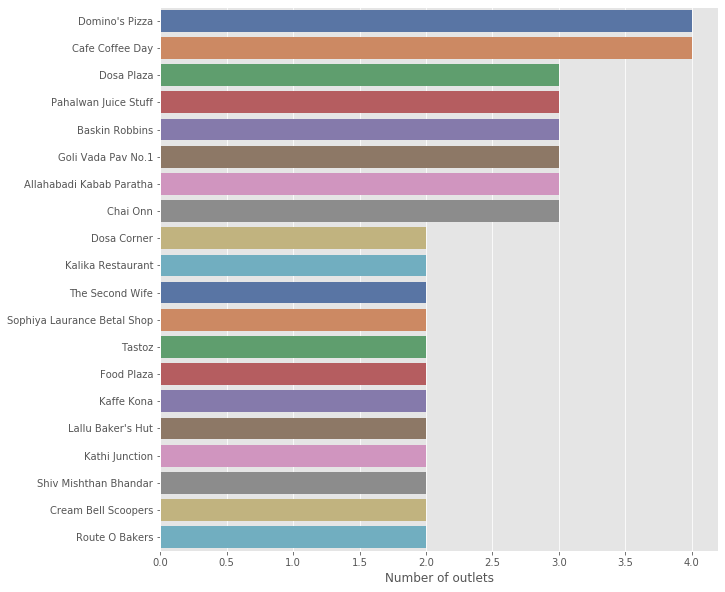

In [10]:
plt.figure(figsize=(10,10))
chains=df['name'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index,palette='deep')
# plt.title("Most famous restaurants chains in Bengaluru")
plt.xlabel("Number of outlets")
plt.savefig(city_name+'/img1.png')

image_name = 'Number of Outlets'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Histogram displaying most famous restaurants chains in Bengaluru',
                       'path': 'img1.png', 'type':'image'}

# fig_dat['number_of_outlets'] = {}
# fig_dat['number_of_outlets']['title'] = "Most famous restaurants chains in Bengaluru"
# fig_dat['number_of_outlets']['long_text'] = "Histogram displaying most famous restaurants chains in Bengaluru"

In [11]:
x=df['online_order'].value_counts()
colors = ['#FEBFB3', '#E1396C']

trace=go.Pie(labels=x.index,values=x,textinfo="value",
            marker=dict(colors=colors, 
                           line=dict(color='#000000', width=2)))
# layout=go.Layout(title="Accepting vs not accepting online orders",width=500,height=500)
fig=go.Figure(data=[trace])
fig.write_html(city_name+"/html1.html")

image_name = 'Order Type'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Pie Chart comparing online and offline orders',
                       'path': 'html1.html', 'type':'html'}


py.iplot(fig, filename='pie_chart_subplots')

In [12]:
x=df['book_table'].value_counts()
colors = ['#96D38C', '#D0F9B1']

trace=go.Pie(labels=x.index,values=x,textinfo="value",
            marker=dict(colors=colors, 
                           line=dict(color='#000000', width=2)))
layout=go.Layout(title="Table booking",width=500,height=500)
fig=go.Figure(data=[trace])

fig.write_html(city_name+"/html2.html")

image_name = 'Booking Type'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Pie chart showing booking types',
                       'path': 'html2.html', 'type':'html'}

py.iplot(fig, filename='pie_chart_subplots')

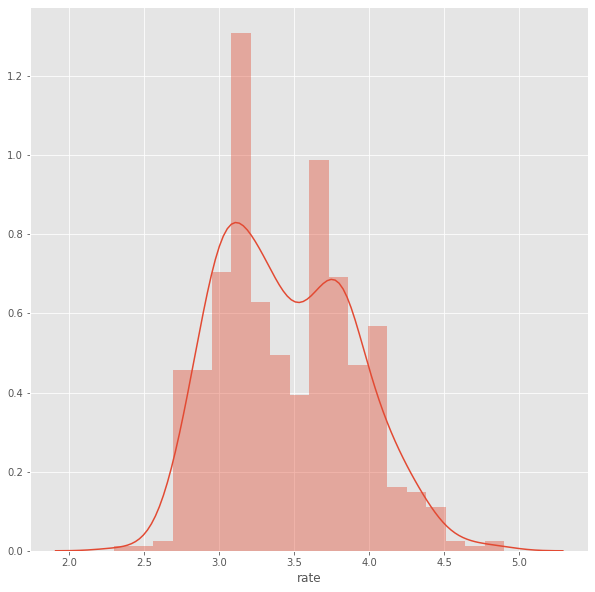

In [13]:
plt.figure(figsize=(10,10))
rating=df['rate'].dropna().apply(lambda x : float(x.split('/')[0]) if (len(x)>3)  else np.nan ).dropna()
sns.distplot(rating,bins=20)
plt.savefig(city_name+'/img2.png')


image_name = 'Histogram of Ratings'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru',
                       'path': 'img2.png', 'type':'image'}

# fig_dat['ratings_hist'] = {}
# fig_dat['ratings_hist']['title'] = "Histogram of Ratings"
# fig_dat['ratings_hist']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

In [14]:
cost_dist=df[['rate','approx_cost','online_order']].dropna()
cost_dist['rate']=cost_dist['rate'].apply(lambda x: float(x.split('/')[0]) if len(x)>3 else 0)
# cost_dist['approx_cost']=cost_dist['approx_cost'].apply(lambda x: int(x.replace(',','')))

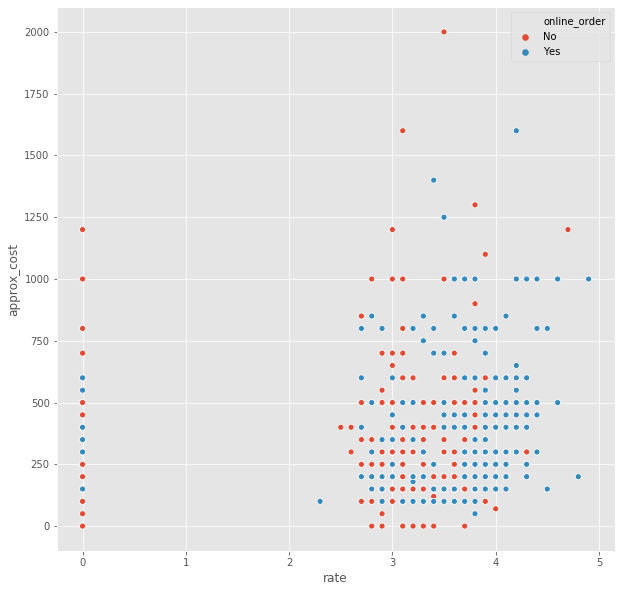

In [15]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="rate",y='approx_cost',hue='online_order',data=cost_dist)
plt.savefig(city_name+'/img3.png')

plt.show()

image_name = 'Approx cost for two'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Approximate cost for two people in the restaurant',
                       'path': 'img3.png', 'type':'image'}

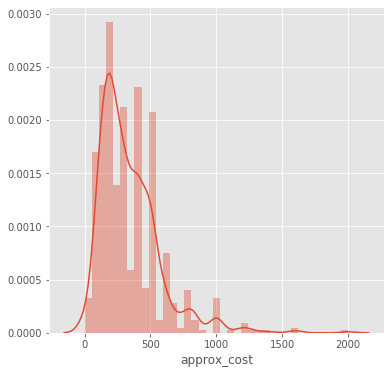

In [16]:
plt.figure(figsize=(6,6))
sns.distplot(cost_dist['approx_cost'])
plt.savefig(city_name+'/img4.png')

plt.show()

image_name = 'Histogram: Approx cost for two'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Histogram plot of approximate cost for two people in the restaurant',
                       'path': 'img4.png', 'type':'image'}

In [17]:
votes_yes=df[df['online_order']=="Yes"]['votes']
trace0=go.Box(y=votes_yes,name="accepting online orders",
              marker = dict(
        color = 'rgb(214, 12, 140)',
    ))

votes_no=df[df['online_order']=="No"]['votes']
trace1=go.Box(y=votes_no,name="Not accepting online orders",
              marker = dict(
        color = 'rgb(0, 128, 128)',
    ))

layout = go.Layout(
    title = "Box Plots of votes",width=800,height=500
)

data=[trace0,trace1]
fig=go.Figure(data=data,layout=layout)

fig.write_html(city_name+"/html3.html")

image_name = 'Votes'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Box plots of votes for online vs offline orders',
                       'path': 'html3.html', 'type':'html'}


py.iplot(fig)

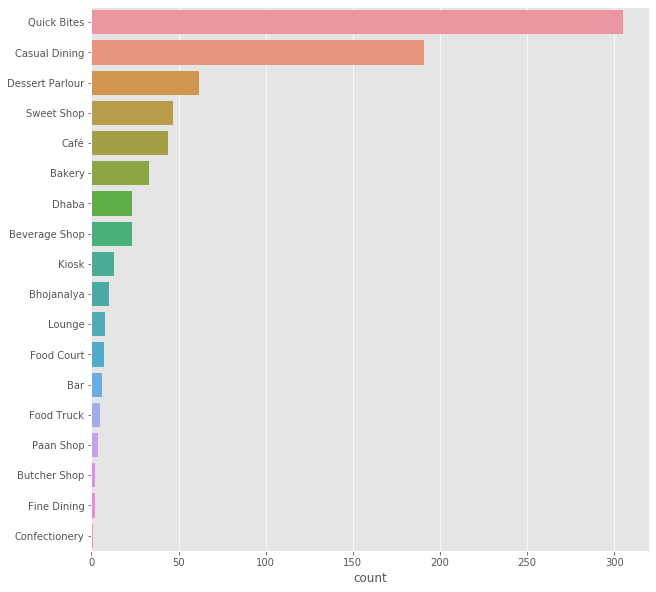

In [18]:
plt.figure(figsize=(10,10))
rest=df['rest_type'].value_counts()[:20]
sns.barplot(rest,rest.index)
plt.xlabel("count")
plt.savefig(city_name+'/img5.png')


image_name = 'Restaurant Types'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Types of restaurants in the city',
                       'path': 'img5.png', 'type':'image'}

# fig_dat['restaurant_types'] = {}
# fig_dat['restaurant_types']['title'] = "Histogram of Ratings"
# fig_dat['restaurant_types']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

In [19]:
trace0=go.Box(y=df['approx_cost'],name="accepting online orders",
              marker = dict(
        color = 'rgb(214, 12, 140)',
    ))
data=[trace0]
layout=go.Layout(title="Box plot of approximate cost",width=800,height=500,yaxis=dict(title="Price"))
fig=go.Figure(data=data,layout=layout)


fig.write_html(city_name+"/html4.html")

image_name = 'Approx Cost'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Box plot for approximate cost for two people',
                       'path': 'html4.html', 'type':'html'}

py.iplot(fig)

In [20]:
cost_dist=df[['rate','approx_cost','location','name','rest_type']].dropna()
cost_dist['rate']=cost_dist['rate'].apply(lambda x: float(x.split('/')[0]) if len(x)>3 else 0)
# cost_dist['approx_cost']=cost_dist['approx_cost'].apply(lambda x: int(x.replace(',','')))

**Function to suggest best restaurant based on location, type of restaurant and cost of meal for two people**

In [21]:
def return_budget(location,rest, cost_for_two):
    budget=cost_dist[(cost_dist['approx_cost']<=cost_for_two) & (cost_dist['location']==location) & 
                     (cost_dist['rate']>4) & (cost_dist['rest_type']==rest)]
    return(budget['name'].unique())

In [22]:
return_budget('Civil Lines',"Quick Bites", 500)

array(['Haldiram Bhujiawala', 'Curry Leaf', 'KFC', 'Chicago Pizza',
       'Nainital Momos', 'Aharam Foods Private Limited', 'Eat On',
       'Coffee Machine The Cafe', 'Hyderabadi Biryani', 'Chunnilal Cafe'],
      dtype=object)

**Food Hotspots**

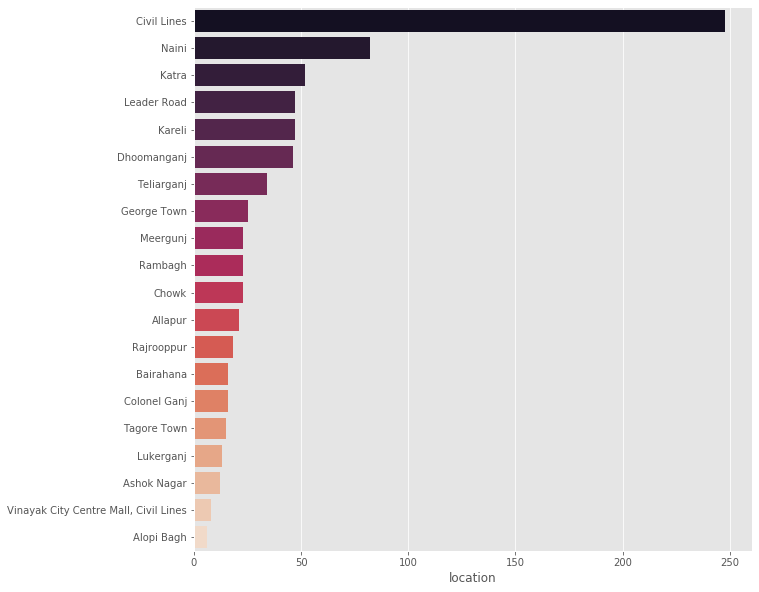

In [23]:
plt.figure(figsize=(10,10))
Rest_locations=df['location'].value_counts()[:20]
sns.barplot(Rest_locations,Rest_locations.index,palette="rocket")
plt.savefig(city_name+'/img6.png')


image_name = 'Location Histogram'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Food Hotspots in the city',
                       'path': 'img6.png', 'type':'image'}

# fig_dat['location_hist'] = {}
# fig_dat['location_hist']['title'] = "Histogram of Ratings"
# fig_dat['location_hist']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

**Top 3 cuisines in each location**

In [24]:
df_1=df.groupby(['location','cuisines']).agg('count')
data=df_1.sort_values(['url'],ascending=False).groupby(['location'],
                as_index=False).apply(lambda x : x.sort_values(by="url",ascending=False).head(3))['url'].reset_index().rename(columns={'url':'count'})

In [25]:
data.head(10)

,level_0,location,cuisines,count
0,0,Allapur,Desserts,3
1,0,Allapur,Fast Food,3
2,0,Allapur,North Indian,3
3,1,Alopi Bagh,Desserts,1
4,1,Alopi Bagh,"Street Food, South Indian, Mithai",1
5,1,Alopi Bagh,North Indian,1
6,2,Ashok Nagar,"Beverages, Cafe, Sandwich, Fast Food, Desserts",2
7,2,Ashok Nagar,North Indian,2
8,2,Ashok Nagar,Paan,1
9,3,Bairahana,Mithai,4


**Extract location coordinates using Geopy**

In [26]:
locations=pd.DataFrame({"Name":df['location'].unique()})
locations['Name']=locations['Name'].apply(lambda x: "Allahabad " + str(x))
lat_lon=[]
geolocator=Nominatim(user_agent="app")
for ind in tqdm(range(locations['Name'].shape[0])):
    location = locations['Name'][ind]
    try:
      location = geolocator.geocode(location)
    except:
      location = None
    if location is None:
        lat_lon.append(np.nan)
    else:    
        geo=(location.latitude,location.longitude)
        lat_lon.append(geo)


locations['geo_loc']=lat_lon
locations.to_csv('locations.csv',index=False)

In [27]:
locations["Name"]=locations['Name'].apply(lambda x :  x.replace("Allahabad","")[1:])
locations.head()

,Name,geo_loc
0,Civil Lines,"(25.4544749, 81.8338255)"
1,George Town,"(25.4505212, 81.8563842)"
2,Tagore Town,"(25.4569942, 81.8636763)"
3,The Legend Hotel,NaN
4,Meergunj,NaN


**Heatmap of restaurant count in each location**

In [28]:
Rest_locations=pd.DataFrame(df['location'].value_counts().reset_index())
Rest_locations.columns=['Name','count']
Rest_locations=Rest_locations.merge(locations,on='Name',how="left").dropna()
Rest_locations['count'].max()

248

In [29]:
def generateBaseMap(default_location=[25.43, 81.84], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [30]:
lat,lon=zip(*np.array(Rest_locations['geo_loc']))
Rest_locations['lat']=lat
Rest_locations['lon']=lon
basemap=generateBaseMap()
HeatMap(Rest_locations[['lat','lon','count']].values.tolist(),max_zoom=20,radius=15).add_to(basemap)

In [31]:
basemap

In [32]:
basemap.save(city_name+'/html5.html')

image_name = 'Restaurant count'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Heatmap of restaurant count in the city',
                       'path': 'html5.html', 'type':'html'}

**Popular Cusinies in the city**

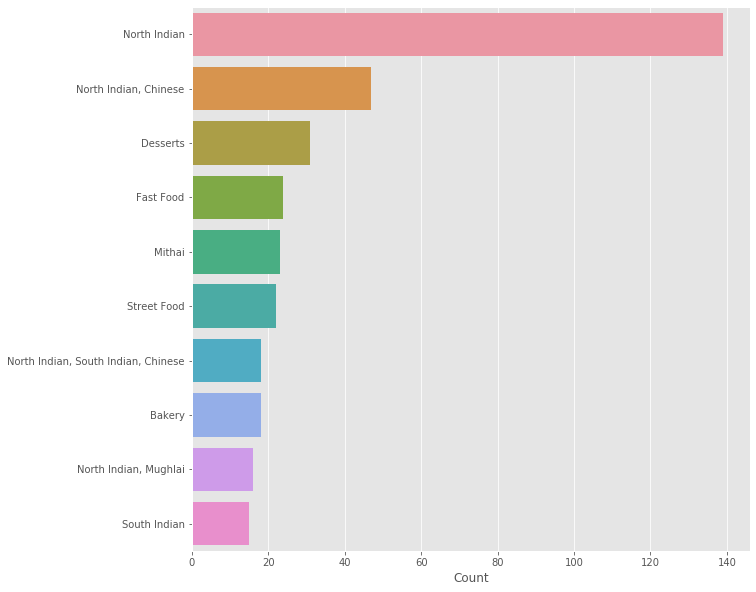

In [33]:
plt.figure(figsize=(10,10))
cuisines=df['cuisines'].value_counts()[:10]
sns.barplot(cuisines,cuisines.index)
plt.xlabel('Count')
plt.savefig(city_name+'/img7.png')

image_name = 'Most Popular Cuisines'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Most popular cuisines in the city',
                       'path': 'img7.png', 'type':'image'}


# fig_dat['most_popular_cuisines_hist'] = {}
# fig_dat['most_popular_cuisines_hist']['title'] = "Histogram of Ratings"
# fig_dat['most_popular_cuisines_hist']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

**Heatmap of North Indian Restaurants**

In [34]:
def produce_data(col,name):
    data= pd.DataFrame(df[df[col]==name].groupby(['location'],as_index=False)['url'].agg('count'))
    data.columns=['Name','count']
    print(data.head())
    data=data.merge(locations,on="Name",how='left').dropna()
    data['lan'],data['lon']=zip(*data['geo_loc'].values)
    return data.drop(['geo_loc'],axis=1)

In [35]:
North_India=produce_data('cuisines','North Indian')

          Name  count
0      Allapur      3
1   Alopi Bagh      1
2  Ashok Nagar      2
3    Bairahana      2
4        Chowk      5


In [36]:
basemap=generateBaseMap()
HeatMap(North_India[['lan','lon','count']].values.tolist(),max_zoom=20,radius=15).add_to(basemap)
basemap

In [37]:
basemap.save(city_name+'/html6.html')

image_name = 'North Indian Restaurants Count'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Heatmap of north indian restaurant count in the city',
                       'path': 'html6.html', 'type':'html'}

**Heatmap of South Indian Restaurants**

In [38]:
food=produce_data('cuisines','South Indian')
basemap=generateBaseMap()
HeatMap(food[['lan','lon','count']].values.tolist(),max_zoom=20,radius=15).add_to(basemap)
basemap

          Name  count
0      Allapur      1
1        Chowk      1
2  Civil Lines      2
3  George Town      2
4       Kareli      1


In [40]:
basemap.save(city_name+'/html7.html')

image_name = 'South Indian Restaurants Count'
fig_dat[image_name] = {'name': image_name, 'longtext': 'Heatmap of south indian restaurant count in the city',
                       'path': 'html7.html', 'type':'html'}

**Analysing Restaurant chains**

In [39]:
def produce_chains(name):
    data_chain=pd.DataFrame(df[df["name"]==name]['location'].value_counts().reset_index())
    data_chain.columns=['Name','count']
    data_chain=data_chain.merge(locations,on="Name",how="left").dropna()
    data_chain['lan'],data_chain['lon']=zip(*data_chain['geo_loc'].values)
    return data_chain[['Name','count','lan','lon']]

In [40]:
df_1=df.groupby(['rest_type','name']).agg('count')
datas=df_1.sort_values(['url'],ascending=False).groupby(['rest_type'],
                as_index=False).apply(lambda x : x.sort_values(by="url",ascending=False).head(3))['url'].reset_index().rename(columns={'url':'count'})

In [41]:
mapbox_access_token="pk.eyJ1Ijoic2hhaHVsZXMiLCJhIjoiY2p4ZTE5NGloMDc2YjNyczBhcDBnZnA5aCJ9.psBECQ2nub0o25PgHcU88w"

Enter the type of restaurant in the next cell

In [42]:
type_ = 'Casual Dining'

casual=datas[datas['rest_type']==type_]
casual

,level_0,rest_type,name,count
17,6,Casual Dining,Dosa Plaza,2
18,6,Casual Dining,The Second Wife,2
19,6,Casual Dining,Shahi Darbar Restaurant,1


In [43]:
def produce_trace(data_chain,name):
        data_chain['text']=data_chain['Name']+'<br>'+data_chain['count'].astype(str)
        trace =  go.Scattermapbox(
           
                lat=data_chain['lan'],
                lon=data_chain['lon'],
                mode='markers',
                marker=go.scattermapbox.Marker(
                    size=data_chain['count']*4
                ),
                text=data_chain['text'],name=name
            )
        
        return trace

In [ ]:
data=[] 
for row in casual['name']:
    data_chain=produce_chains(row) 
    trace_0=produce_trace(data_chain,row)
    data.append(trace_0)



layout = go.Layout(title="Casual Dining Restaurant chains locations around Allahabad",
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,style="streets",
        center=dict(
            lat=12.96,
            lon=77.59
        ),
        pitch=0,
        zoom=10
    ),
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Montreal Mapbox')

**Word Cloud of liked dishes**

In [45]:
df['dish_liked'].head()

0                                                  NaN
1                                                  NaN
2                                                  NaN
3                                              Biryani
4    Paneer Tikka, Biryani, Kulfi, Phirni, Mutton S...
Name: dish_liked, dtype: object

In [46]:
df['dish_liked']=df['dish_liked'].apply(lambda x : x.split(',') if type(x)==str else [''])

In [47]:
fig_dat

{'Number of Outlets': {'name': 'Number of Outlets',
  'longtext': 'Histogram displaying most famous restaurants chains in Bengaluru',
  'path': 'img1.png',
  'type': 'image'},
 'Order Type': {'name': 'Order Type',
  'longtext': 'Pie Chart comparing online and offline orders',
  'path': 'html1.html',
  'type': 'html'},
 'Booking Type': {'name': 'Booking Type',
  'longtext': 'Pie chart showing booking types',
  'path': 'html2.html',
  'type': 'html'},
 'Histogram of Ratings': {'name': 'Histogram of Ratings',
  'longtext': 'Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru',
  'path': 'img2.png',
  'type': 'image'},
 'Approx cost for two': {'name': 'Approx cost for two',
  'longtext': 'Approximate cost for two people in the restaurant',
  'path': 'img3.png',
  'type': 'image'},
 'Histogram: Approx cost for two': {'name': 'Histogram: Approx cost for two',
  'longtext': 'Histogram plot of approximate cost for two people in the restaurant',
  'path': 'img

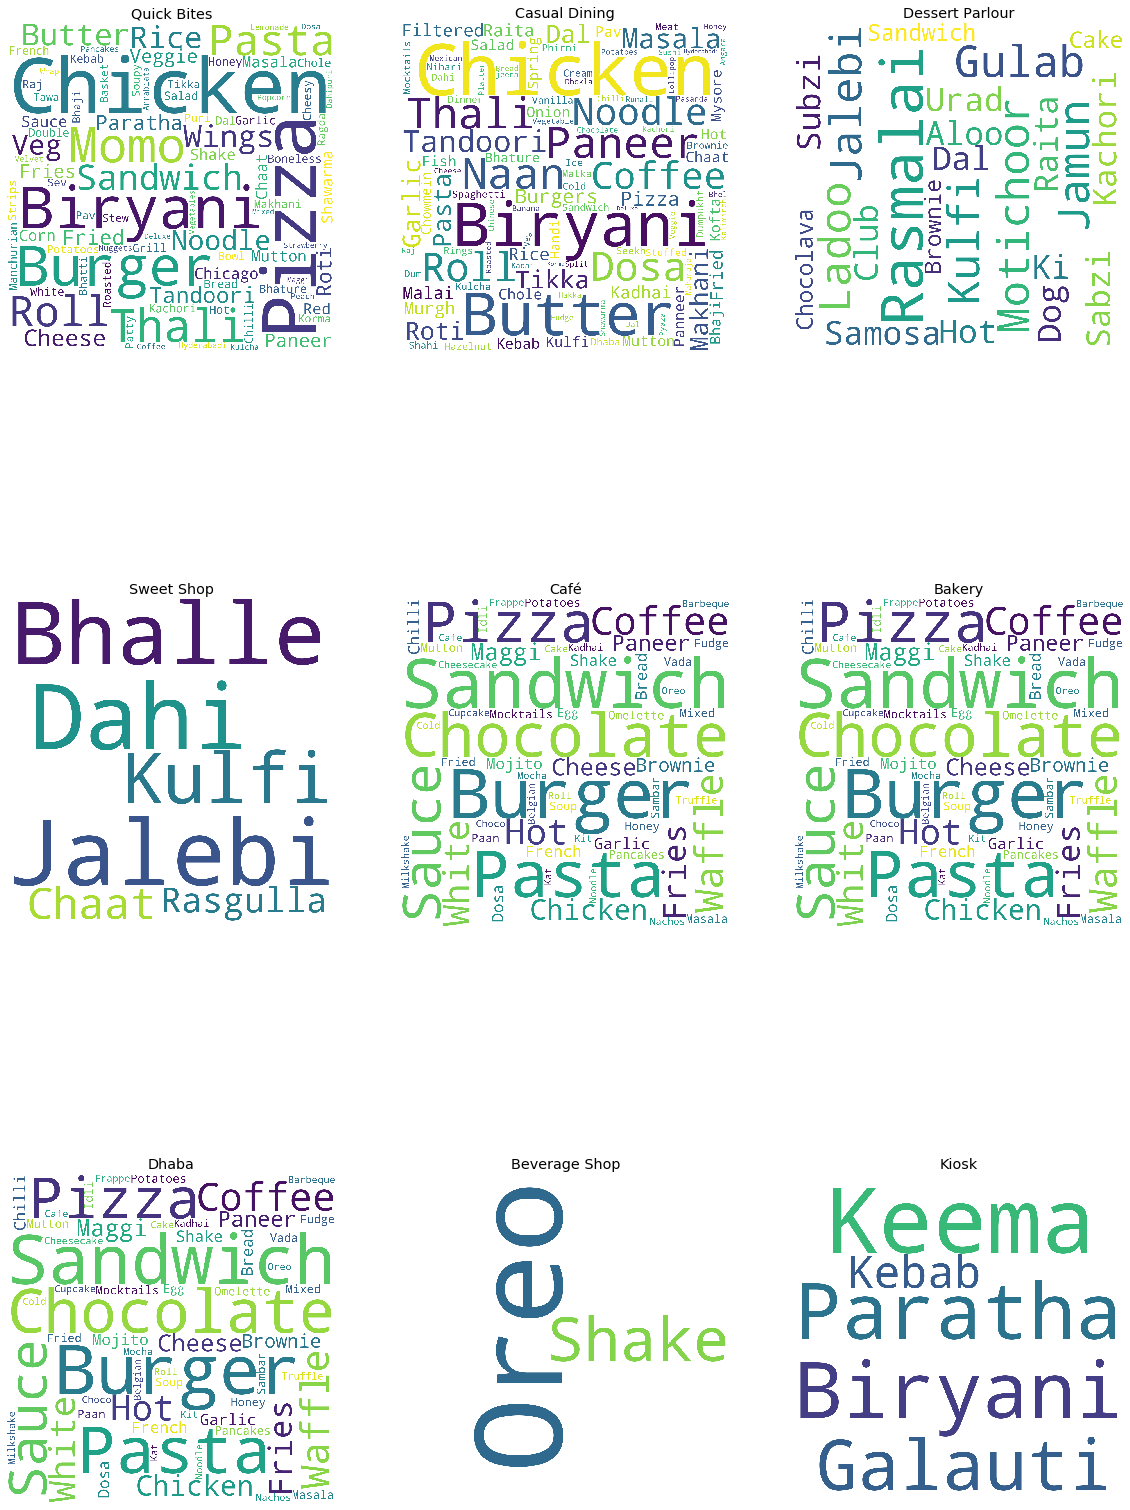

In [48]:
rest=df['rest_type'].value_counts()[:].index
def produce_wordcloud(rest):
    
    plt.figure(figsize=(20,30))
    for i,r in enumerate(rest):
        plt.subplot(3,3,i+1)
        corpus=df[df['rest_type']==r]['dish_liked'].values.tolist()
        corpus=','.join(x  for list_words in corpus for x in list_words)
        
        try:
            wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                          width=1500, height=1500).generate(corpus)
        except:
            pass
        
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
        
    image_name = 'Popular dishes'
    
    plt.savefig(city_name+'/img8.png')
    fig_dat[image_name] = {'name': image_name, 'longtext': 'Wordcloud of popular dishes',
                           'path': 'img8.png', 'type':'image'}
      
produce_wordcloud(rest[:9])

**Analysing Reviews**

In [49]:
all_ratings = []

for name,ratings in tqdm(zip(df['name'],df['reviews'])):
    ratings = eval(ratings)
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            score = float(score)
            all_ratings.append([name,score, doc])

In [50]:
rating_df=pd.DataFrame(all_ratings,columns=['name','rating','review'])
rating_df['review']=rating_df['review'].apply(lambda x : re.sub('[^a-zA-Z0-9\s]',"",x))

In [51]:
rating_df.to_csv("Ratings.csv")

In [52]:
rating_df.head()

,name,rating,review
0,Rang Mahal - Hotel Ajay International,3.0,Food is tasty and service is also good but the...
1,Rang Mahal - Hotel Ajay International,4.0,egular visitors from past fifften years food i...
2,Rang Mahal - Hotel Ajay International,4.0,Super restaurant You can order just anything I...
3,Rang Mahal - Hotel Ajay International,3.5,xcellent place for party purposes Quite pocket...
4,Rang Mahal - Hotel Ajay International,4.0,his is one of our must visit places during our...


**WordCloud of Reviews of restaurant chains**

ValueError: We need at least 1 word to plot a word cloud, got 0.

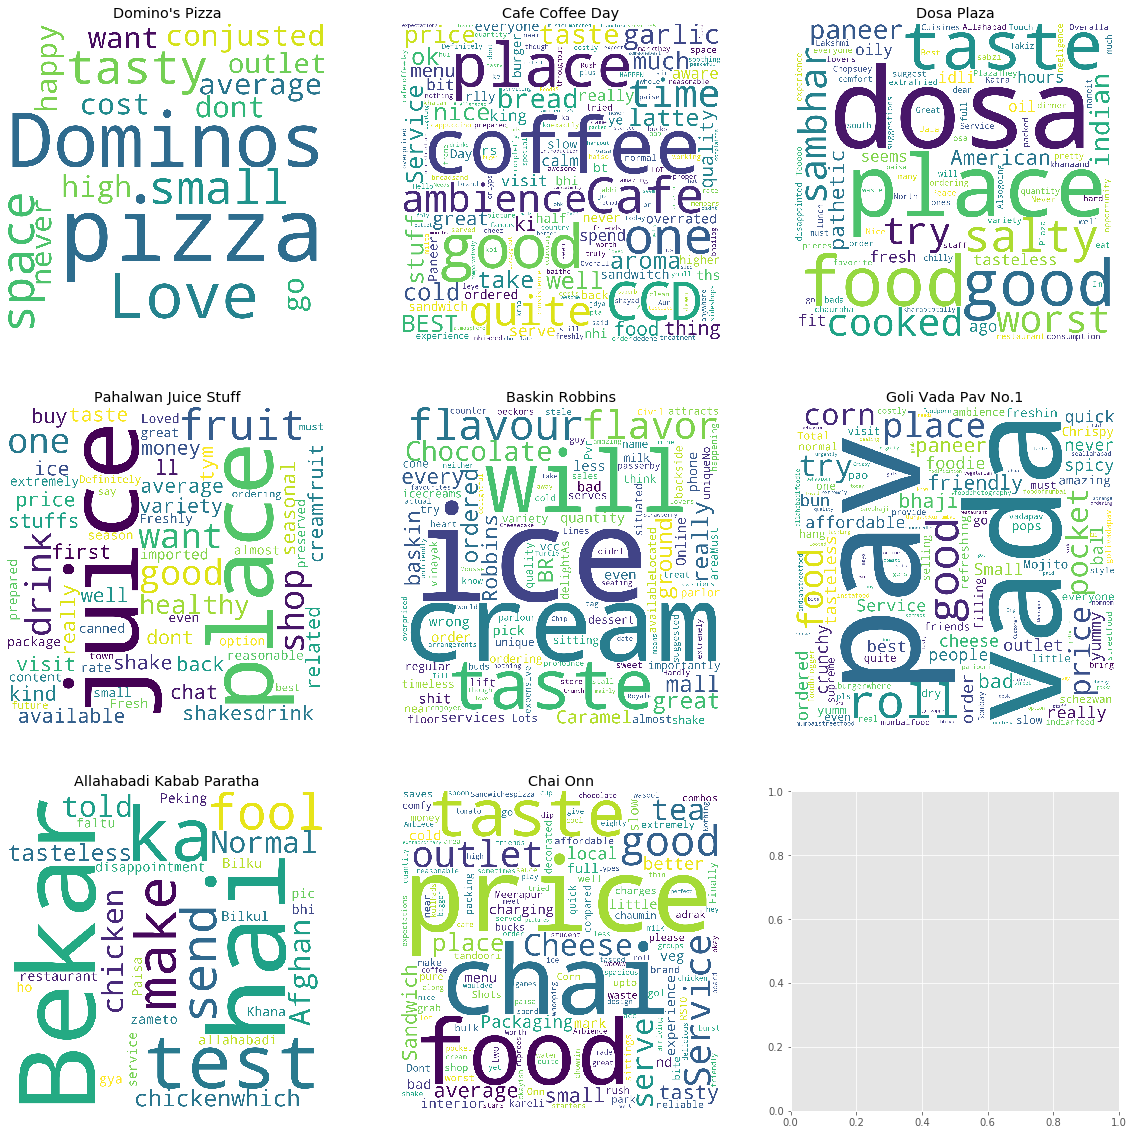

In [54]:
rest=df['name'].value_counts()[:9].index
def produce_wordcloud(rest):
    
    plt.figure(figsize=(20,20))
    for i,r in enumerate(rest):
        plt.subplot(3,3,i+1)
        corpus=rating_df[rating_df['name']==r]['review'].values.tolist()
        corpus=' '.join(x  for x in corpus)
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1500, height=1500).generate(corpus)
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
        

    image_name = 'Reviews'
    
    plt.savefig(city_name+'/img9.png')
    fig_dat[image_name] = {'name': image_name, 'longtext': 'Wordcloud of reviews of various restaurants',
                           'path': 'img9.png', 'type':'image'} 
        
produce_wordcloud(rest[:8])

**Rating Distribution**

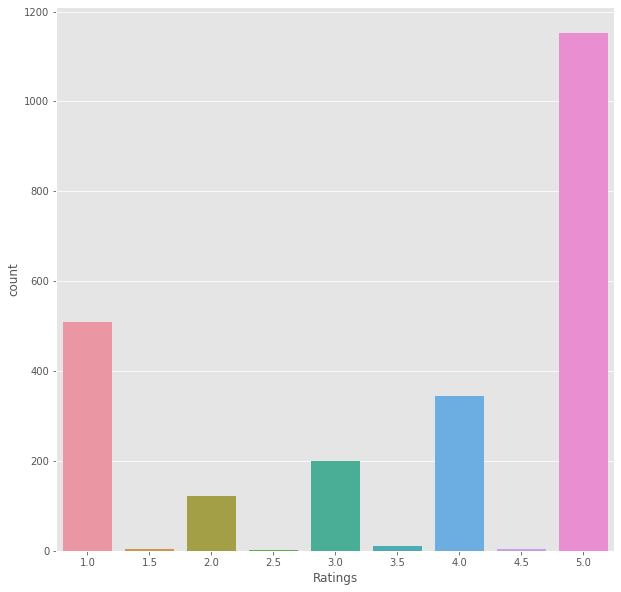

In [237]:
plt.figure(figsize=(10,10))
rating=rating_df['rating'].value_counts()
sns.barplot(x=rating.index,y=rating)
plt.xlabel("Ratings")
plt.ylabel('count')


image_name = 'Ratings'
    
plt.savefig(city_name+'/img10.png')
fig_dat[image_name] = {'name': image_name, 'longtext': 'Ratings given by user',
                       'path': 'img10.png', 'type':'image'}


fig_dat['ratings_hist'] = {}
fig_dat['ratings_hist']['title'] = "Histogram of Ratings"
fig_dat['ratings_hist']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

In [238]:
rating_df['sent']=rating_df['rating'].apply(lambda x: 1 if int(x)>2.5 else 0)

In [239]:
with open(city_name+'/data.json', 'w') as fp:
    json.dump(fig_dat, fp, sort_keys=True)

# NLP Part: Text Processing

**Analysing Positive comments: rating>=2.5**

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

In [ ]:
stops=stopwords.words('english')
lem=WordNetLemmatizer()
corpus=' '.join(lem.lemmatize(x) for x in rating_df[rating_df['sent']==1]['review'][:3000] if x not in stops)
tokens=word_tokenize(corpus)

In [ ]:
vect=TfidfVectorizer()
vect_fit=vect.fit(tokens)

In [ ]:
id_map=dict((v,k) for k,v in vect.vocabulary_.items())
vectorized_data=vect_fit.transform(tokens)
gensim_corpus=gensim.matutils.Sparse2Corpus(vectorized_data,documents_columns=False)
ldamodel = gensim.models.ldamodel.LdaModel(gensim_corpus,id2word=id_map,num_topics=5,random_state=34,passes=25)

In [ ]:
counter=Counter(corpus)

In [ ]:
out=[]
topics=ldamodel.show_topics(formatted=False)
for i,topic in topics:
    for word,weight in topic:
        out.append([word,i,weight,counter[word]])

dataframe = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        


# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.3, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=8)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(dataframe.loc[dataframe.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=8, y=1.05)    
plt.show()
plt.savefig(city_name+'/word_count_and_topic.png')
fig_dat['word_count_and_topic'] = {}
fig_dat['word_count_and_topic']['title'] = "Histogram of Ratings"
fig_dat['word_count_and_topic']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

**Analysing negative reviews: rating < 2.5**

In [ ]:
stops=stopwords.words('english')
lem=WordNetLemmatizer()
corpus=' '.join(lem.lemmatize(x) for x in rating_df[rating_df['sent']==0]['review'][:3000] if x not in stops)
tokens=word_tokenize(corpus)

In [ ]:
vect=TfidfVectorizer()
vect_fit=vect.fit(tokens)
id_map=dict((v,k) for k,v in vect.vocabulary_.items())
vectorized_data=vect_fit.transform(tokens)
gensim_corpus=gensim.matutils.Sparse2Corpus(vectorized_data,documents_columns=False)
ldamodel = gensim.models.ldamodel.LdaModel(gensim_corpus,id2word=id_map,num_topics=5,random_state=34,passes=25)

In [ ]:
counter=Counter(corpus)
out=[]
topics=ldamodel.show_topics(formatted=False)
for i,topic in topics:
    for word,weight in topic:
        out.append([word,i,weight,counter[word]])

dataframe = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        


# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.3, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=8)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(dataframe.loc[dataframe.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=8, y=1.05)    
plt.show()
plt.savefig(city_name+'/word_count_and_topic2.png')
fig_dat['word_count_and_topic2'] = {}
fig_dat['word_count_and_topic2']['title'] = "Histogram of Ratings"
fig_dat['word_count_and_topic2']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"


*   We can clearly observe the difference between the two types of comments
*   The words used are clearly distinguishable.
*   The words used in negative comments are clearly critisizing.
*   The word used in positive comments are clearly appreciating.






**Visualising Word Space using tSNE**

In [ ]:
stops=set(stopwords.words('english'))
lem=WordNetLemmatizer()
corpus=[]
for review in tqdm(rating_df['review'][:10000]):
    words=[]
    for x in word_tokenize(review):
        x=lem.lemmatize(x.lower())
        if x not in stops:
            words.append(x)
            
    corpus.append(words)

In [ ]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    plt.savefig(city_name+'/word_scatter.png')
    fig_dat['word_scatter'] = {}
    fig_dat['word_scatter']['title'] = "Histogram of Ratings"
    fig_dat['word_scatter']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

In [ ]:
tsne_plot(model)

**tSNE of adjectives used in positive reviews**

In [ ]:
postive=rating_df[rating_df['rating']>3]['review'][:2000]
negative=rating_df[rating_df['rating']<2.5]['review'][:2000]

def return_corpus(df):
    corpus=[]
    for review in df:
        tagged=nltk.pos_tag(word_tokenize(review))
        adj=[]
        for x in tagged:
            if x[1]=='JJ':
                adj.append(x[0])
        corpus.append(adj)
    return corpus

In [ ]:
nltk.download('averaged_perceptron_tagger')

corpus=return_corpus(postive)
model = word2vec.Word2Vec(corpus, size=100, min_count=10,window=20, workers=4)
tsne_plot(model)

In [ ]:
corpus=return_corpus(negative)
model = word2vec.Word2Vec(corpus, size=100, min_count=10,window=20, workers=4)
tsne_plot(model)

# NLP Part: Sentiment Analysis

In [ ]:
rating_df['sent']=rating_df['rating'].apply(lambda x: 1 if int(x)>2.5 else 0)

In [ ]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(rating_df['review'].values)
X = tokenizer.texts_to_sequences(rating_df['review'].values)
X = pad_sequences(X)

In [ ]:
embed_dim = 32
lstm_out = 32

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
#model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

In [ ]:
Y = pd.get_dummies(rating_df['sent'].astype(int)).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [ ]:
batch_size = 3200
model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size)

In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

## Creating Data Jason

In [ ]:
import os


In [ ]:
data = {'count': len(df), 'data':{}}

In [ ]:

for root, dirs, files in os.walk(city_name, topdown=False):
    for file in files:
        if '.png' in file:
            data['data'][fig_dat[file[:-4]]['title']] = {}
            data['data'][fig_dat[file[:-4]]['title']]['longtext'] = fig_dat[file[:-4]]['long_text']
            data['data'][fig_dat[file[:-4]]['title']]['path'] = city_name+'/'+file
            data['data'][fig_dat[file[:-4]]['title']]['name'] = fig_dat[file[:-4]]['title']

In [ ]:
data

In [ ]:
import json

In [ ]:
with open(city_name+'/data.json', 'w') as fp:
    json.dump(data, fp)

In [ ]:
import os
import sys
 
pid = os.fork()
 
if pid > 0:
    print("This is written by the parent process")
else:
    os.execl(sys.executable, 'python3', "hello.py", *sys.argv[1:])
    os._exit(0)